In [6]:
import os
import datetime
import string
import re
import numpy as np
import pandas as pd
import gdown
import nltk
import seaborn as sns
nltk.download('stopwords')
from gensim.parsing.preprocessing import remove_stopwords
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drebi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
data_url = "https://drive.google.com/drive/folders/1zQGlgh5kHTXSq7eoyXf6i_uAWYFJ5xzx?usp=share_link"

current_path = os.getcwd()

data_folder_path = os.path.join(os.getcwd(), 'genie_data')

In [8]:
if not os.path.exists(data_folder_path):

    os.makedirs(data_folder_path)
    print(f'Downloading data from Google Drive to {data_folder_path}')
    gdown.download_folder(data_url,output=data_folder_path, quiet=True, use_cookies=False)
else:
    print(f'Directory already exists: {data_folder_path}')

In [9]:
start_date = '2005-01-01'
end_date = '2020-12-31'

In [10]:
headlines_data = pd.read_csv('genie_data/raw_partner_headlines.csv')
headlines_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A


In [11]:
headlines_data.shape # defines the shape of dataframe.

(1845559, 6)

In [12]:
headlines_data["date"] = pd.to_datetime(headlines_data["date"]) # convert string to datetime component

headlines_data["year"] = headlines_data["date"].dt.year         # Extract year from date component

In [13]:
# Filter the data by year.
headlines_data = headlines_data[(headlines_data['year'] >= 2005) & (headlines_data['year'] <= 2020)] 

In [14]:
headlines_data.shape # Size of the dataset.

(1845558, 7)

In [15]:
# Remove any duplicates from the dataset.
headlines_data = headlines_data.drop_duplicates(subset=['headline', 'stock','date'], keep='first')

In [16]:
headlines_data.shape # there were 22843 duplicate records.

(1822715, 7)

In [17]:
def filter_records(df, stock, possible_phrases):
    """ 
    This function helps to return new dataframe with the relacent news.
    """
    
    search_phrase = " | ".join(possible_phrases)
    new_df = df.loc[(df['stock'] == stock) | (headlines_data['headline'].str.contains(search_phrase, case=False))]
    new_df = new_df.reset_index().sort_values(by='date')
    return new_df[["date","headline"]]

In [18]:
# apply filter to each ticker.

ENPH_headlines    = filter_records(headlines_data,"ENPH",["Enphase Energy Inc","Enphase Energy","ENPH"])
KEY_headlines     = filter_records(headlines_data,"KEY",["KeyCorp","KeyBank"])
DAL_headlines     = filter_records(headlines_data,"DAL",["Delta Airlines Corp","Delta Airlines","DEL"])
LNC_headlines     = filter_records(headlines_data,"LNC",["Lincoln National Corp","Lincoln National","LNC"])
ETSY_headlines    = filter_records(headlines_data,"ETSY",["Etsy Inc","Etsy"])

XEL_headlines     = filter_records(headlines_data,"XEL",["Xcel Energy Inc","Xcel Energy","XEL"])
PG_headlines      = filter_records(headlines_data,"PG",["P&G","Procter & Gamble Co","Procter & Gamble","PG"])
LNT_headlines     = filter_records(headlines_data,"LNT",["Alliant","Alliant Energy","Alliant Energy Corporation","LNT"])
PEP_headlines     = filter_records(headlines_data,"PEP",["PepsiCo"])
D_headlines       = filter_records(headlines_data,"D",["Dominion Energy Inc","Dominion Energy"])

In [19]:
def process_sentence(sentence):
    """
    Process the sentence to convert to lowercase, remove digits, puntuation, and stopwords.
    """

    l_sentence = sentence.lower()                       # Converts the sentence to lowercase.
    rd_sentence = re.sub(r'\d+', '', l_sentence)        # Remove the digits from the sentence.
    plain_sentence = rd_sentence.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    plain_sentence = plain_sentence.strip()
    return remove_stopwords(plain_sentence)


In [20]:
def get_sentiment_polarity(sentence):
    """
    Returns the sentiment polarity of the sentence provided.
    """

    processes_sentence = process_sentence(sentence)
    return TextBlob(
        processes_sentence
    ).sentiment.polarity  # Return the sentence sentiment polarity/ score.

In [21]:
ENPH_headlines["SentimentScore"] = ENPH_headlines["headline"].apply(
    get_sentiment_polarity
)
KEY_headlines["SentimentScore"] = KEY_headlines["headline"].apply(
    get_sentiment_polarity
)
DAL_headlines["SentimentScore"] = DAL_headlines["headline"].apply(
    get_sentiment_polarity
)
LNC_headlines["SentimentScore"] = LNC_headlines["headline"].apply(
    get_sentiment_polarity
)
ETSY_headlines["SentimentScore"] = ETSY_headlines["headline"].apply(
    get_sentiment_polarity
)


XEL_headlines["SentimentScore"] = XEL_headlines["headline"].apply(
    get_sentiment_polarity
)
PG_headlines["SentimentScore"] = PG_headlines["headline"].apply(get_sentiment_polarity)
LNT_headlines["SentimentScore"] = LNT_headlines["headline"].apply(
    get_sentiment_polarity
)
PEP_headlines["SentimentScore"] = PEP_headlines["headline"].apply(
    get_sentiment_polarity
)
D_headlines["SentimentScore"] = D_headlines["headline"].apply(get_sentiment_polarity)

In [22]:
# Generate a intermediate dataframe with continuous dates in them.

dates_list = pd.date_range(start=start_date, end=end_date)
dates_df = pd.DataFrame({'date': dates_list})
dates_df

,date
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05
...,...
5839,2020-12-27
5840,2020-12-28
5841,2020-12-29
5842,2020-12-30


In [23]:
def add_missing_date(df):
    return df.merge(dates_df, on='date', how='outer')

In [24]:
ENPH_sentiment_scores  = add_missing_date(ENPH_headlines)[["date","SentimentScore"]]
KEY_sentiment_scores   = add_missing_date(KEY_headlines)[["date","SentimentScore"]]
DAL_sentiment_scores   = add_missing_date(DAL_headlines)[["date","SentimentScore"]]
LNC_sentiment_scores   = add_missing_date(LNC_headlines)[["date","SentimentScore"]]
ETSY_sentiment_scores  = add_missing_date(ETSY_headlines)[["date","SentimentScore"]]

XEL_sentiment_scores   = add_missing_date(XEL_headlines)[["date","SentimentScore"]]
PG_sentiment_scores    = add_missing_date(PG_headlines)[["date","SentimentScore"]]
LNT_sentiment_scores   = add_missing_date(LNT_headlines)[["date","SentimentScore"]]
PEP_sentiment_scores   = add_missing_date(PEP_headlines)[["date","SentimentScore"]]
D_sentiment_scores     = add_missing_date(D_headlines)[["date","SentimentScore"]]

In [25]:
ENPH_sentiment_scores[ENPH_sentiment_scores["SentimentScore"]>0]

,date,SentimentScore
3720,2015-03-06,0.500000
3721,2015-03-06,0.500000
3722,2015-03-06,0.500000
3723,2015-03-06,0.500000
3724,2015-03-06,0.500000
...,...,...
5717,2020-03-31,0.100000
5735,2020-04-13,1.000000
5739,2020-04-14,0.433333
5741,2020-04-15,0.800000


In [26]:
# Replace the None values with 0

ENPH_sentiment_scores.fillna(0, inplace=True)
KEY_sentiment_scores.fillna(0, inplace=True)
DAL_sentiment_scores.fillna(0, inplace=True)
LNC_sentiment_scores.fillna(0, inplace=True)
ETSY_sentiment_scores.fillna(0, inplace=True)

XEL_sentiment_scores.fillna(0, inplace=True)
PG_sentiment_scores.fillna(0, inplace=True)
LNT_sentiment_scores.fillna(0, inplace=True)
PEP_sentiment_scores.fillna(0, inplace=True)
D_sentiment_scores.fillna(0, inplace=True)

In [27]:
# Add Tic to each stock dataframe 
ENPH_sentiment_scores["tic"]  = "ENPH"
KEY_sentiment_scores["tic"]   = "KEY"
DAL_sentiment_scores["tic"]   = "DAL"
LNC_sentiment_scores["tic"]   = "LNC"
ETSY_sentiment_scores["tic"]  = "ETSY"
 
XEL_sentiment_scores["tic"]   = "XEL"
PG_sentiment_scores["tic"]    = "PG"
LNT_sentiment_scores["tic"]   = "LNT"
PEP_sentiment_scores["tic"]   = "PEP"
D_sentiment_scores["tic"]     = "D"

In [28]:
# Concat the dataframes and sort by dates
sentiment_scores_df = pd.concat([ENPH_sentiment_scores,
                                 KEY_sentiment_scores,
                                 DAL_sentiment_scores,
                                 LNC_sentiment_scores,
                                 ETSY_sentiment_scores,
                                 XEL_sentiment_scores,
                                 PG_sentiment_scores,
                                 LNT_sentiment_scores,
                                 PEP_sentiment_scores,
                                 D_sentiment_scores
                                ],axis=0).sort_values(by='date')

In [29]:
sentiment_scores_df

,date,SentimentScore,tic
0,2005-01-01,0.0,ENPH
0,2005-01-01,0.0,LNC
0,2005-01-01,0.0,ETSY
0,2005-01-01,0.0,XEL
0,2005-01-01,0.0,PG
...,...,...,...
7427,2020-12-31,0.0,KEY
6218,2020-12-31,0.0,LNT
6010,2020-12-31,0.0,ENPH
6213,2020-12-31,0.0,XEL


In [30]:
def generate_word_cloud(sentences,ticker):
    """Generatees the word cloud for the list of sentenses provided."""
    
    processed_sentnces = list(map(process_sentence,sentences))
    combines_sentence = " ".join(processed_sentnces)
    mask = np.array(Image.open("./genie_data/cloud.png"))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_words=50, mask=mask, stopwords=stopwords, background_color="white").generate(combines_sentence)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Wordcloud for stock: {ticker}")
    plt.axis("off")
    plt.show()

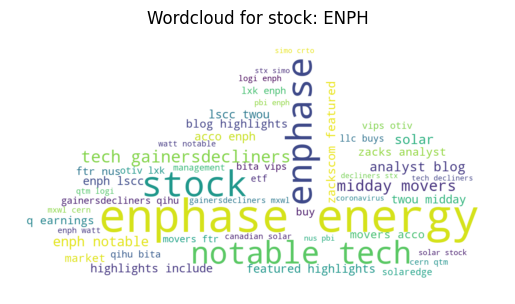

In [31]:
generate_word_cloud(ENPH_headlines['headline'], 'ENPH')

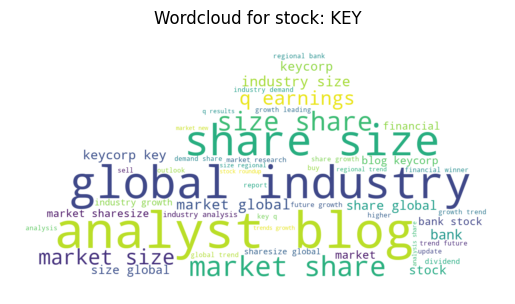

In [32]:
generate_word_cloud(KEY_headlines['headline'], 'KEY')

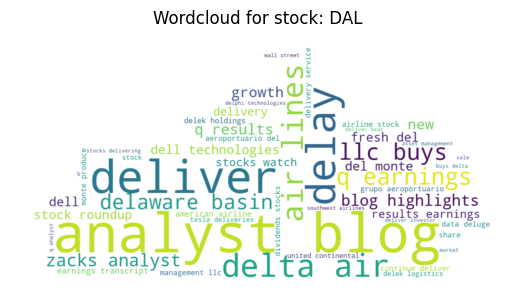

In [33]:
generate_word_cloud(DAL_headlines['headline'], 'DAL')

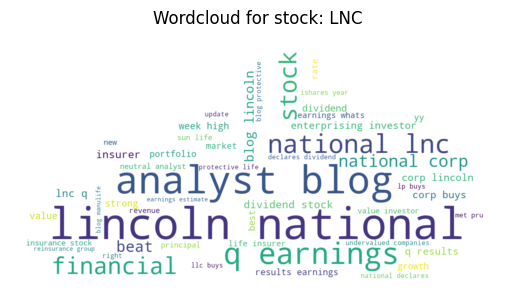

In [34]:
generate_word_cloud(LNC_headlines['headline'], 'LNC')

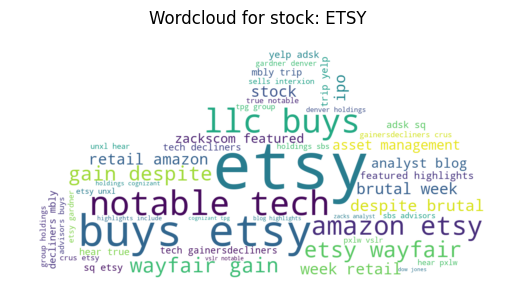

In [35]:
generate_word_cloud(ETSY_headlines['headline'], 'ETSY')

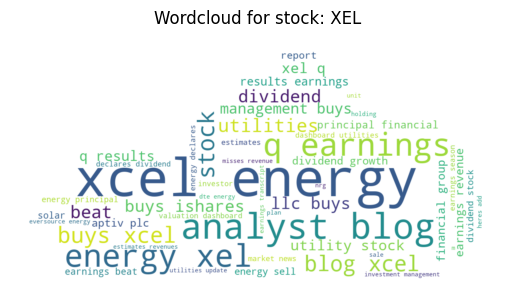

In [36]:
generate_word_cloud(XEL_headlines['headline'], 'XEL')

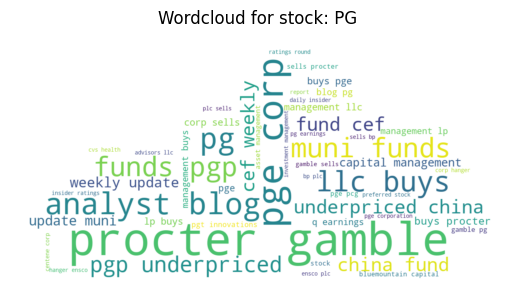

In [37]:
generate_word_cloud(PG_headlines['headline'], 'PG')

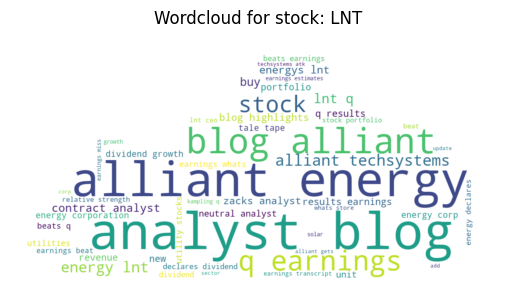

In [38]:
generate_word_cloud(LNT_headlines['headline'], 'LNT')

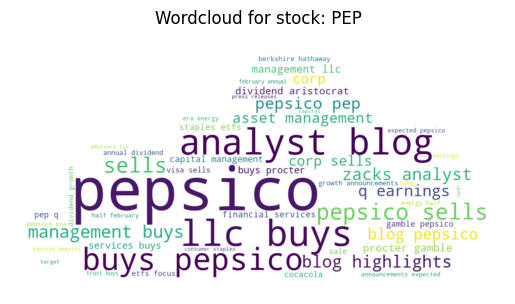

In [39]:
generate_word_cloud(PEP_headlines['headline'], 'PEP')

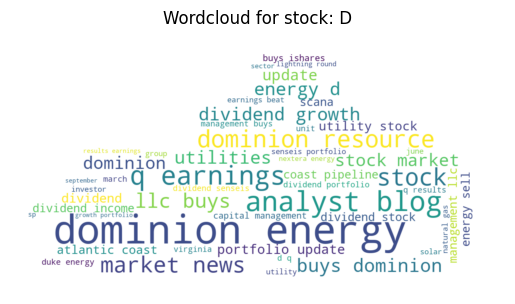

In [40]:
generate_word_cloud(D_headlines['headline'], 'D')

C:\Users\drebi\AppData\Local\Temp\ipykernel_27908\207113044.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sentiment_scores_df[(sentiment_scores_df['tic']==tic)


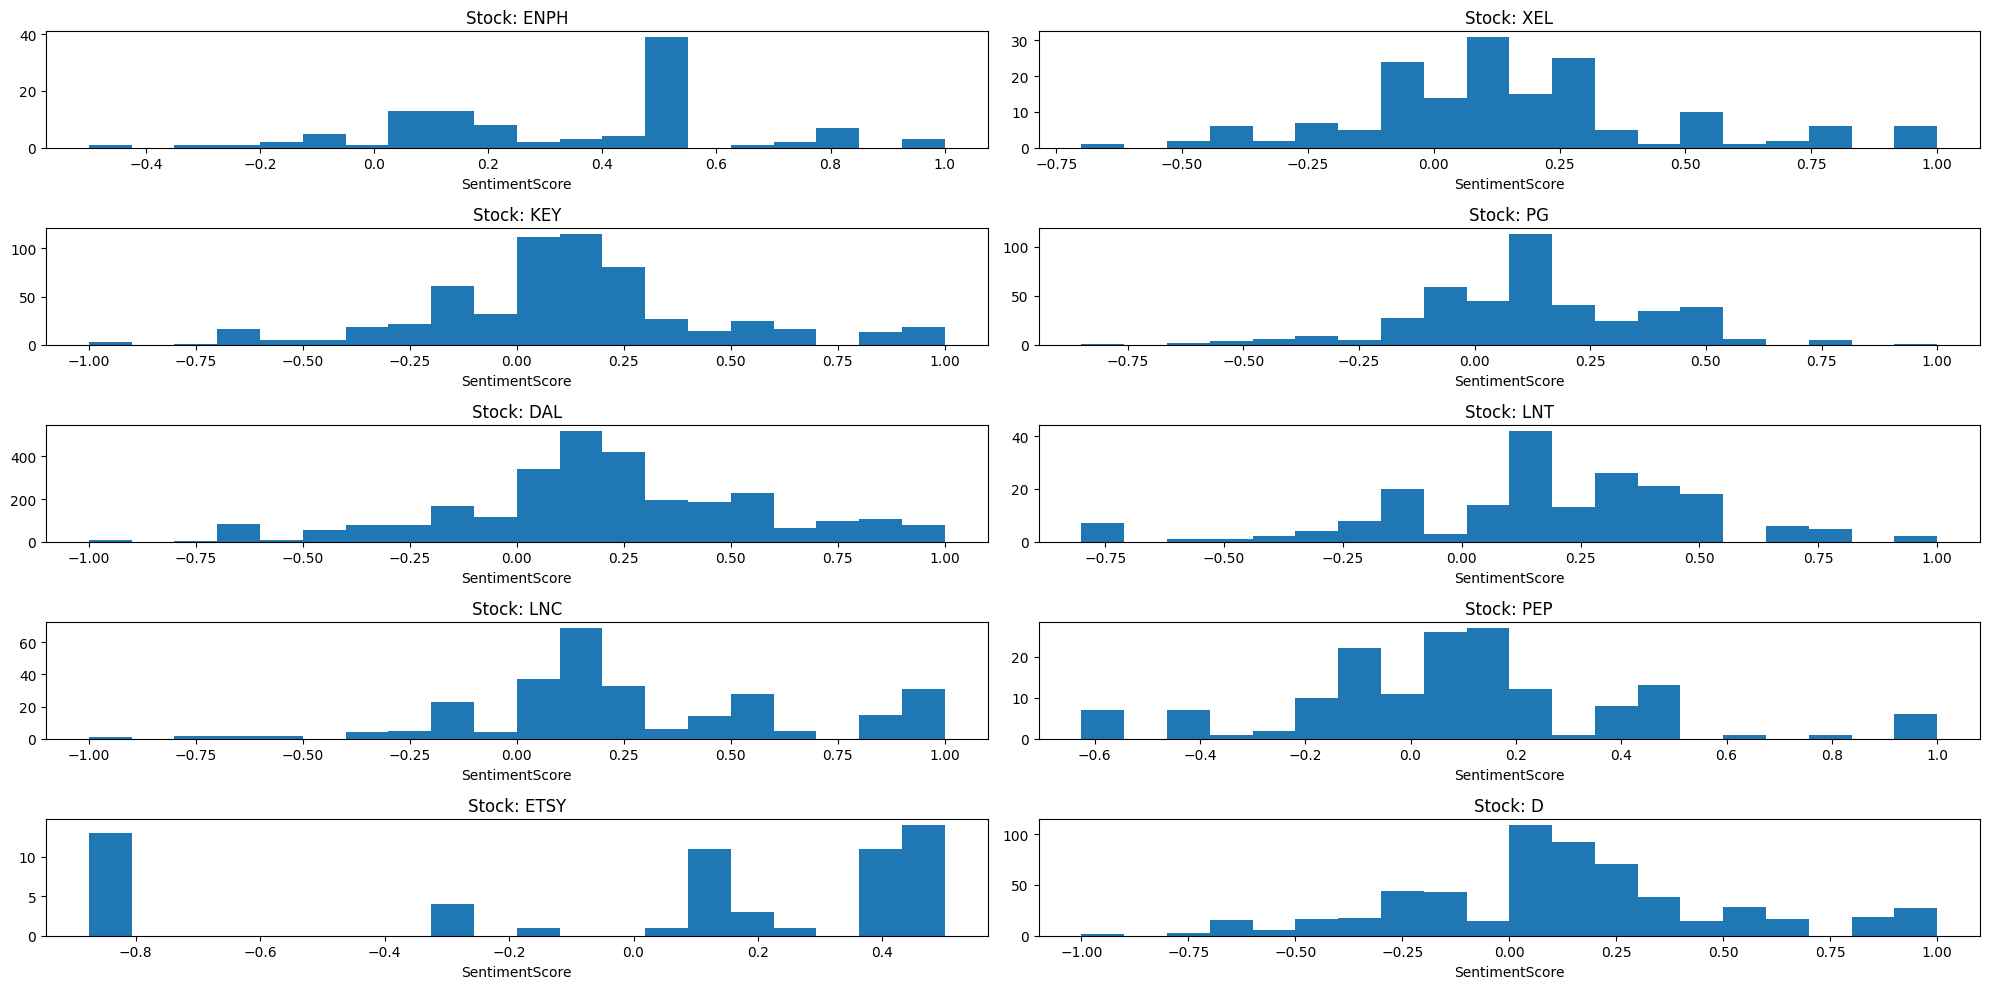

In [41]:
# create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 10))

# loop over categories and plot histograms
selected_tickers = ["ENPH","XEL","KEY","PG","DAL","LNT","LNC","PEP","ETSY","D"]

for i, tic in enumerate(selected_tickers):
    row = i // 2
    col = i % 2
    ax = axs[row][col]
    sns.distplot(sentiment_scores_df[(sentiment_scores_df['tic']==tic)
                                     & (sentiment_scores_df['SentimentScore']!=0)]['SentimentScore']
                 , norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1},ax=ax)
    ax.set_title(f'Stock: {tic}')

# adjust layout
plt.tight_layout()
plt.show()

In [42]:
sentiment_scores_df.to_csv('./genie_data/sentiments_df.csv')